# Tuning Results: Profiles

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

In [3]:
module_path = os.path.abspath(os.path.join('..'))
# Relative imports
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import pickle
import numpy as np
import copy
from pathlib import Path

In [5]:
from pcmasking.utils.utils import read_ancilaries, find_closest_value, find_closest_longitude  
from pcmasking.utils.variable import Variable_Lev_Metadata
from pcmasking.neural_networks.cbrain.cam_constants import *

In [6]:
import matplotlib.transforms as mtransforms
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [7]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [8]:
font_size = 11

In [9]:
plt.rcParams["font.size"] = font_size
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Computer Modern"] + plt.rcParams["font.serif"]
plt.rcParams["mathtext.default"] = "regular"

In [10]:
def parse_txt_to_list(txt_file):
    line_list = list()
    with open(txt_file, 'r') as f:
        for line in f:
            line_list.append(line.rstrip())
    return line_list

In [11]:
def load_pickle(f_name):
    with open(f_name, "rb") as f:
        values = pickle.load(f)
    return values

In [12]:
def save_figures(file_name):
    for format in save_formats:        
        f_path = os.path.join(output_dir, f"{variable}_{file_name}.{format}")

        fig.savefig(f_path, format=format, bbox_inches="tight", transparent=True)
    
        print(f"\nSaved figure {f_path}")

## Tuning Directories

In [13]:
# PROJECT_ROOT = Path.cwd().parent.resolve()
PROJECT_ROOT = Path("/p/scratch/icon-a-ml/kuehbacher1")

In [14]:
tuning_dirs = ["training_88_mask_net_prediction_thresholds_spars1.0", 
        "training_89_mask_net_prediction_thresholds_spars0.1",
        "training_90_mask_net_prediction_thresholds_spars0.01",
        "training_91_mask_net_prediction_thresholds_spars0.001",
        "training_92_mask_net_prediction_thresholds_spars1e-4",
        "training_93_mask_net_prediction_thresholds_spars1e-5", 
]
train_val = "train"

In [15]:
labels = [r"$\lambda_{spars} = 1.0$", 
          r"$\lambda_{spars} = 0.1$", 
          r"$\lambda_{spars} = 0.01$", 
          r"$\lambda_{spars} = 0.001$", 
          r"$\lambda_{spars} = 10^{-4}$", 
          r"$\lambda_{spars} = 10^{-5}$"
         ]

In [16]:
variable = "tphystnd" # tphystnd, phq 
stats = "r2"

In [17]:
save_formats = ["pdf", "svg"]

## Causally-informed NN

In [18]:
causal_plot_dir = os.path.join(PROJECT_ROOT, "output", "eval_nando", "causal_single_nn", 
                          "models_arch-rasp_thrs-opt-mse6", "plots_offline_evaluation")
causal_profile_dir = os.path.join(causal_plot_dir, "plots_profiles", f"range-1440_lats-90_90_lons0.0_359.0_stats-{stats}")

In [19]:
causal_profiles = dict()

causal_profiles["truth"] = load_pickle(os.path.join(causal_profile_dir, f"{variable}_profile_truth.p"))
causal_profiles["pred"] = load_pickle(os.path.join(causal_profile_dir, f"{variable}_profile_pred.p"))
causal_profiles[stats] = load_pickle(os.path.join(causal_profile_dir, f"{variable}_stats-{stats}.p"))

## Load Data

In [20]:
profiles_tuning = {d: dict() for d in tuning_dirs}

for d in tuning_dirs:
    bd = os.path.join(PROJECT_ROOT, "output", d )
    plots_dir = os.path.join(bd, "plots_offline_evaluation")
    outputs_list_file = os.path.join(bd, "outputs_list.txt")

    profile_dir = os.path.join(plots_dir, f"plots_profiles_{train_val}", f"range-1440_lats-90_90_lons0.0_359.0_stats-{stats}")
    
    cfg = os.path.join(bd, "cfg_mask_net.yml")
    outputs_list = parse_txt_to_list(outputs_list_file)

    
    profiles_tuning[d]["truth"] = load_pickle(os.path.join(profile_dir, f"{variable}_profile_truth.p"))
    profiles_tuning[d]["pred"] = load_pickle(os.path.join(profile_dir, f"{variable}_profile_pred.p"))
    profiles_tuning[d][stats] = load_pickle(os.path.join(profile_dir, f"{variable}_stats-{stats}.p"))

In [21]:
output_dir = os.path.join(PROJECT_ROOT, "output", "tuning_results")
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [22]:
def plot_tuning_profiles_and_r2(fig, ax):
    
    units = {"tphystnd": r"$K/s$", "phq": r"$kg/(kg \cdot s)$"}
    var_label = {"tphystnd": r"$\Delta T_{phy}$", "phq": r"$\Delta q_{phy}$"}

    best = "training_91_mask_net_prediction_thresholds_spars0.001"

    vmin = np.min([np.min(profiles_tuning[best]["pred"]), np.min(profiles_tuning[best]["truth"])])
    vmax = np.max([np.max(profiles_tuning[best]["pred"]), np.max(profiles_tuning[best]["truth"])])
    vlim = np.max([np.abs(vmin), np.abs(vmax)]) / 2.
    vmin = -vlim;
    vmax = vlim
    
    colors  = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

    last_neg_index = 10
    #######################
    # Plot Pred
    lines_pred = list()
    
    for i, d in enumerate(tuning_dirs): 
        arr = np.mean(profiles_tuning[d]["pred"], axis=0)
        if variable == "phq": 
            print(f"Last negative index: {last_neg_index} ({outputs_list[30 + last_neg_index]})")
            print(f"Start plot from index {last_neg_index + 1} ({outputs_list[30 + last_neg_index +1]})")

            l, = ax.plot(arr[last_neg_index + 1:], P[last_neg_index + 1:], label=labels[i], color=colors[i])
        else: 
            l, = ax.plot(arr, P, label=labels[i], color=colors[i])
            
        lines_pred.append(l)

    truth = profiles_tuning[tuning_dirs[0]]["truth"]

    if variable == "phq":
        line_truth, = ax.plot(np.mean(truth, axis=0)[last_neg_index + 1], 
                              P[last_neg_index + 1], label="SPCAM", color=colors[i+1])
        line_pred_causal, = ax.plot(np.mean(causal_profiles["pred"], axis=0)[last_neg_index + 1], 
                                    P[last_neg_index + 1], label="CI-NN", 
                                    linestyle="dotted", color=colors[i+2])
        
    else:
        line_truth, = ax.plot(np.mean(truth, axis=0), P, label="SPCAM", color=colors[i+1])
        line_pred_causal, = ax.plot(np.mean(causal_profiles["pred"], axis=0), P, label="CI-NN", 
                                     linestyle="dotted", color=colors[i+2])

    ax.set_ylim(P[0], P[-1])
    ax.set_xlim(vmin, vmax)

    ax.tick_params(bottom=True, left=True, length=2)
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)


    ax.set_yticks([200, 400, 600, 800])
    
    ax.set_xlabel(f'{var_label[variable]} ({units[variable]})')
    
    ax.set_ylabel('Pressure (hPa)')
  
    
    # Invert the Y-axis
    ax.invert_yaxis()
    ax.set_rasterized(True)

    ax.set_title("Tuning Predictions", fontsize=font_size)

    if variable == "phq":
        plt.legend(prop={'size': 12}, loc="upper right")
    else: 
        plt.legend(prop={'size': 12}, loc="center right")


    #######################
    # Plot R2
    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("right", size="100%", pad=.15, sharey=ax)

    for i, d in enumerate(tuning_dirs): 
        arr = np.mean(profiles_tuning[d][stats], axis=1)

        if variable == "phq": 
            print(f"Last negative index: {last_neg_index} ({outputs_list[30 + last_neg_index]})")
            print(f"Start plot from index {last_neg_index + 1} ({outputs_list[30 + last_neg_index +1]})")
    
            line_r2, = ax2.plot(arr[last_neg_index+1:], P[last_neg_index + 1:], label=labels[i], color=colors[i])  
        else:     
            line_r2, = ax2.plot(arr, P, label=labels[i], color=colors[i])

    
    arr_causal = np.mean(causal_profiles[stats], axis=1)
    if variable == "phq":
        line_r2_causal, = ax2.plot(arr_causal[last_neg_index+1:], P[last_neg_index + 1:], label="CI-NN",
                                   linestyle="dotted", color=colors[i+2])  
    else:             
        line_r2_causal, = ax2.plot(arr_causal, P, label="CI-NN",linestyle="dotted", color=colors[i+2])  

    ax2.tick_params(bottom=True, left=True, length=2)
    ax2.tick_params(axis='x', labelsize=font_size)
    ax2.tick_params(axis='y', labelsize=font_size, labelleft=False)

    ax2.set_xlabel(f'{var_label[variable]} ({units[variable]})')
    
  
    ax2.set_xlim(-0.05, 1.05)
    ax2.set_xlabel(r'$R^2$ Score')
    
    ax2.set_rasterized(True)
    
    ax2.set_title(f"Tuning $R^{2}$ Scores", fontsize=font_size)
   


Saved figure /p/scratch/icon-a-ml/kuehbacher1/output/tuning_results/tphystnd_tuning_profiles_and_r2.pdf

Saved figure /p/scratch/icon-a-ml/kuehbacher1/output/tuning_results/tphystnd_tuning_profiles_and_r2.svg


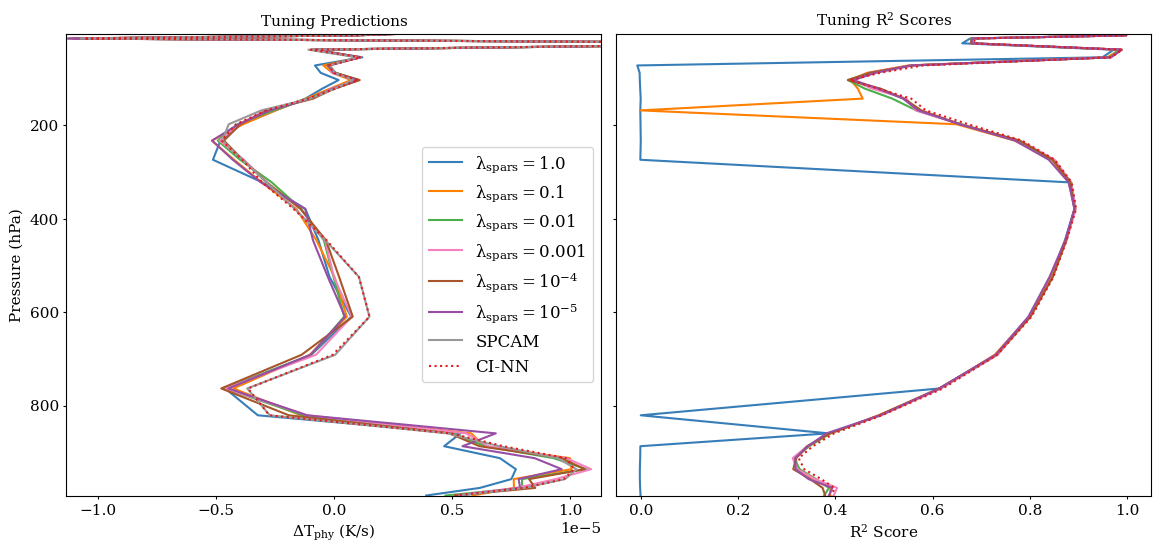

In [23]:
plt.close()
fig, ax = plt.subplots(figsize=(14, 6))

plot_tuning_profiles_and_r2(fig, ax)

if variable == "phq":
    f_name = "tuning_profiles_and_r2_cutoff_168"
else: 
    f_name = "tuning_profiles_and_r2"

save_figures(f_name)